In [2]:
###################################################################读入原始数据
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# import xlrd
import sqlite3
import math
mpl.rcParams['figure.figsize'] = (18,9)
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [3]:
def get_channel_data(file=''):
    wb = xlrd.open_workbook(filename=file)
    table = wb.sheet_by_index(0)
    nrows = table.nrows
    data =[] #装读取结果的序列
    for rn in range(1, nrows): #遍历每一行的内容
        row = table.row_values(rn) #根据行号获取行
        if row: #如果行存在
            data.append(row[1:])
    data = np.array(data)
    return data
'73349f35-8315-4e82-b402-f3f130db91b9' #8000
'6d804191-3423-4150-b8fc-90941b48d02d' #3000
'b26c2399-8bef-4760-a125-e439b273b82e' #280

'b26c2399-8bef-4760-a125-e439b273b82e'

In [4]:
#读取原始数据
# fileA = 'A通道2018-10-17 154702──2018-10-22 042403.xlsx'
# fileB = 'B通道2018-10-17 154702──2018-10-22 042403.xlsx'
# ChAAll = get_channel_data(file=fileA)
# ChBAll = get_channel_data(file=fileB)
conn = sqlite3.connect(r'D:\Project\Lidar\LidarServer\LidarServer\app.db')
c = conn.cursor()
ChAAll = []
ChBAll = []
cursor = c.execute("SELECT raw_A,raw_B from task_data where task_id='73349f35-8315-4e82-b402-f3f130db91b9'")
for row in cursor:
    dt = np.dtype(int)
    dt = dt.newbyteorder('<')
    chA = np.frombuffer(row[0], dtype=dt)
    chB = np.frombuffer(row[1], dtype=dt)
    ChAAll.append(chA)
    ChBAll.append(chB)

In [20]:
def aerosol_calc(chA,chB,overlapA,overlapB,resolution=15,snrT=2,pblT=0.3,rc=15000,sa=40,waveLen=532,verAngle=90):
    r = np.arange(len(chA))+1
    r = r*resolution
    bn=int(len(chA)*5/6)
    bgA = np.mean(chA[bn:])
    bgB = np.mean(chB[bn:])
    noise = np.std(chA[bn:]+chB[bn:])
    chACutBg = chA-bgA
    chBCutBg = chB-bgB
    snr = (chACutBg+chBCutBg)/noise
    chACutBg = chACutBg/overlapA
    chBCutBg = chBCutBg/overlapB
    dePolar = np.where(chACutBg!=0,chBCutBg/chACutBg,0)
    chAPR2 = chACutBg*r*r/1e6
    chBPR2 = chBCutBg*r*r/1e6 
    chPR2 = chAPR2+chBPR2
    sn0 = int(300/resolution)
    sn1 = int(1000/resolution)
    chMax = chPR2[sn0:sn1].max()
    chPR2N = np.where(snr>snrT,chPR2,chMax/200)
    chPR2N = np.where(chPR2N>0.8*chMax,0.8*chMax,chPR2N)
    pblIndex = np.where(chPR2N<pblT*chMax)[0][0]
    if(pblIndex<sn0):
        pblIndex = sn0
    pbl = pblIndex*resolution
    beta_m = 1.54e-3*np.exp(-r*math.sin(verAngle)/7000)*math.pow(532/waveLen,4)
    rcn = int(rc/resolution)
    beta_sf = np.cumsum(beta_m[rcn:])*-1
    beta_sb = np.cumsum(beta_m[:rcn][::-1])[::-1]
    beta_s = np.concatenate((beta_sb,beta_sf))
    sm = 8*math.pi/3
    Xr = chPR2N*np.exp(2*(sa-sm)*resolution*1e-3*beta_s)
    Xrf = np.cumsum(Xr[rcn:])*-1
    Xrb = np.cumsum(Xr[:rcn][::-1])[::-1]
    Xrs = np.concatenate((Xrb,Xrf))*2*sa*resolution*1e-3
    beta = Xr/(10000+Xrs)
    beta_a = beta - beta_m
    ext_a = sa*beta_a
    return chAPR2,chBPR2,dePolar,ext_a,pbl

In [21]:
resolution = 15
r = np.arange(resolution,30000.1,resolution)
ov = np.loadtxt(r'19000101000000_15.ov')
overlapA = ov[:,0]
overlapB = ov[:,1]
# overlapA = np.ones(2000)
# overlapB = np.ones(2000)
Ext = []
chAPR2All = []
chBPR2All = []
for i in range(len(ChAAll)):
    chA = ChAAll[i]
    chB = ChBAll[i]
    chAPR2,chBPR2,dePolar,ext_a,pbl = aerosol_calc(chA,chB,overlapA,overlapB,resolution=resolution,snrT=1.5,rc=15000)
    Ext.append(ext_a)
    chAPR2All.append(chAPR2)
    chBPR2All.append(chBPR2)

C:\ProgramData\Anaconda3\envs\arcgis\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\ProgramData\Anaconda3\envs\arcgis\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


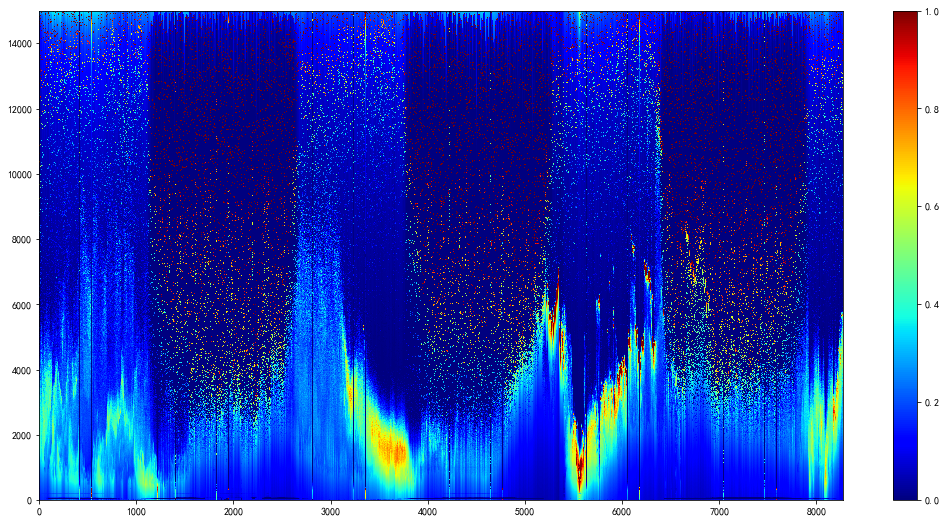

In [22]:
x = np.arange(len(ChAAll))
ArrayExt = np.array(Ext)[:,:1000]
y = r[:1000]
plt.pcolormesh(x, y, np.transpose(ArrayExt), cmap = 'jet',vmin=0,vmax=1)
plt.colorbar()

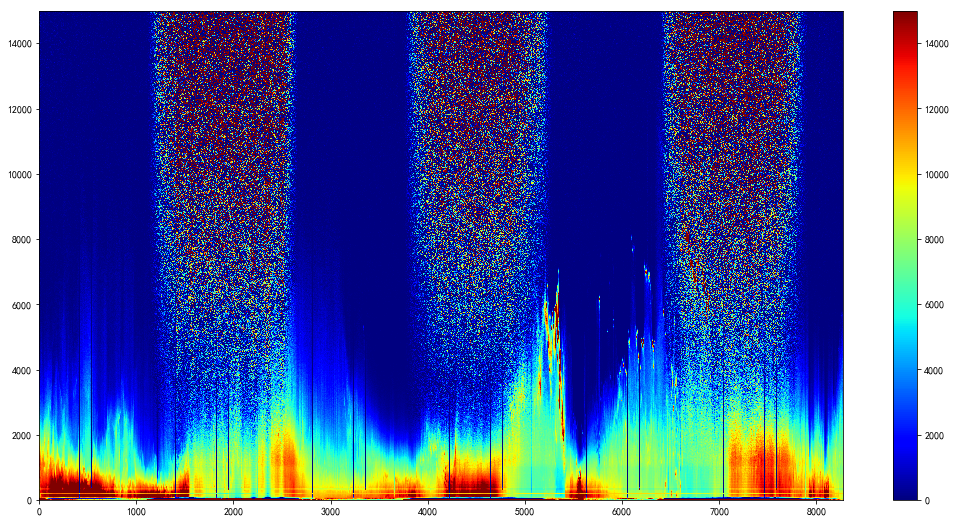

In [23]:
ArrayChAPR2 = np.array(chAPR2All)[:,:1000]
plt.pcolormesh(x, y, np.transpose(ArrayChAPR2), cmap = 'jet',vmin=0,vmax=15000)
plt.colorbar()

C:\ProgramData\Anaconda3\envs\arcgis\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\arcgis\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


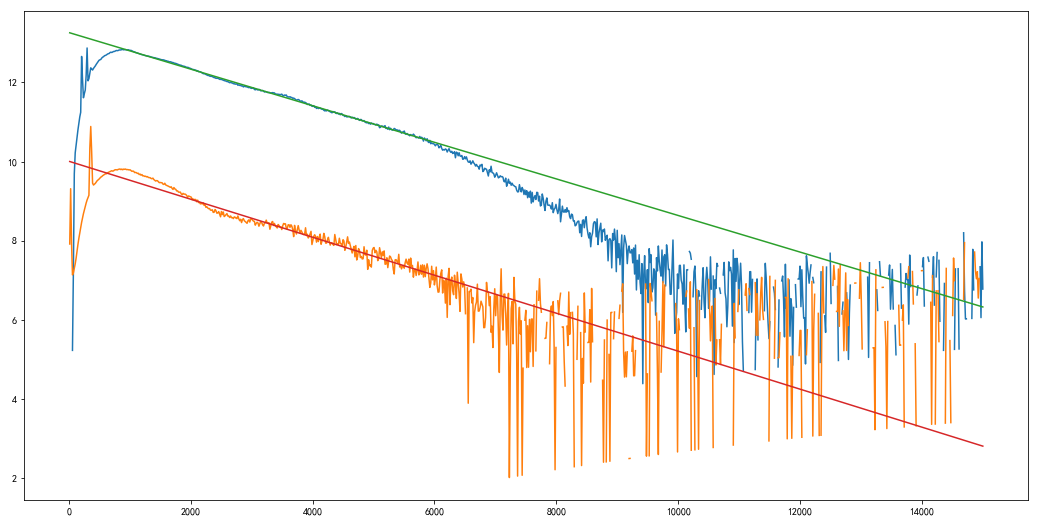

In [17]:
chAPR2S = np.sum(chAPR2All[2900:2950],axis=0)
chBPR2S = np.sum(chBPR2All[2900:2950],axis=0)
chAPR2Log = np.log(chAPR2S)
chBPR2Log = np.log(chBPR2S)
zA = np.polyfit(y[100:300]/1000, chAPR2Log[100:300], 1)
zB = np.polyfit(y[100:300]/1000, chBPR2Log[100:300], 1)
pA = np.poly1d(zA)
pB = np.poly1d(zB)
chAPR2Fit = pA(r/1000)
chBPR2Fit = pB(r/1000)
plt.plot(y, chAPR2Log[:1000])
plt.plot(y, chBPR2Log[:1000])
plt.plot(y, chAPR2Fit[:1000])
plt.plot(y, chBPR2Fit[:1000])

In [16]:
zA,zB,len(chBPR2Fit)

(array([-0.46226871, 13.26129259]), array([-0.47991659, 10.00932196]), 1000)

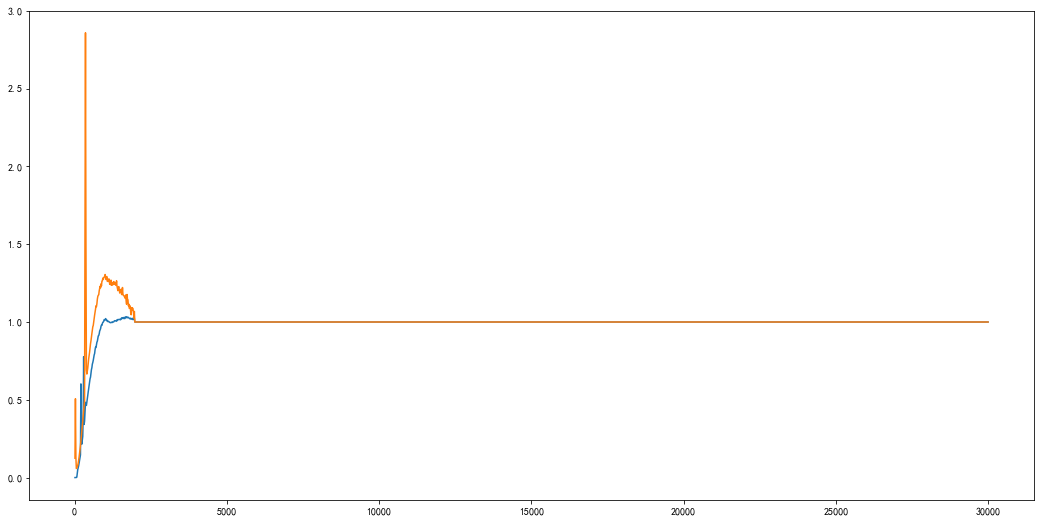

In [18]:
ovA = chAPR2S/np.exp(chAPR2Fit)
ovB = chBPR2S/np.exp(chBPR2Fit)
ovA[131:] = 1
ovB[131:] = 1
plt.plot(r, ovA)
plt.plot(r, ovB)

In [27]:
np.savetxt('19000101000000_15.ov', np.column_stack((ovA,ovB)),fmt='%.8f')

In [31]:
len(overlapA)

2000